# Evaluation of the model

In [1]:
import os
import csv
import pickle
import numpy as np
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import random
import datetime
import scipy.stats as sp 
from matplotlib import cm
import imageio
import pandas as pd

In [112]:
log_dir = "./log" 
FIGSIZE = (15,9)
LW = 3
plt.rcParams.update({'font.size': 10})

In [3]:
def plot_performance(means,stds,X=None,names=None,title="",ylabel="performance", minimum = -np.inf, maximum=np.inf,
                     log=False, double =False, xlabel="learning episodes"):
    if names is None:
        names = [str(j) for j in range(len(means))]
    compute_X = (X is None)
    if len(means)<6:
        ncol = [1,1,2,2,3][len(means)-1] 
    else:
        ncol = len(means)//2
    fig, ax = plt.subplots(figsize=FIGSIZE)
    colors = ['blueviolet','royalblue','crimson','darkgreen','orange']
    handles = []
    for i in range(len(means)):
        if (double and i>=len(means)/2):
            linestyle = ":"
            color = colors[i%(len(means)//2)]
        else:
            linestyle = "-"
            color = colors[i%len(colors)]
        
        mean, std = np.array(means[i]), np.array(stds[i])
        mean_p_std = np.minimum(mean+std, maximum)
        mean_m_std = np.maximum(mean-std, minimum)
        
        if compute_X:
            X = [x for x in range(len(mean))]
        plt.plot(X,mean, color = color,lw=LW, linestyle=linestyle)
        ax.fill_between(X,mean_p_std , mean_m_std, color= color, alpha=0.15)
        plt.plot(X, mean_p_std, color=color, alpha=0.2)
        plt.plot(X, mean_m_std, color=color, alpha=0.2)
        handles.append( mlines.Line2D([], [], color = color, linestyle=linestyle, label= names[i]))
    if log:
        plt.yscale("log")
        if (X[1]-X[0])!=(X[-1]-X[-2]):
            plt.xscale("log")
    else:
        if minimum != -np.inf and maximum!=np.inf:
            plt.ylim(minimum,maximum)
        elif minimum != -np.inf:
            plt.ylim(minimum)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(handles=handles, numpoints = 2,ncol=1,bbox_to_anchor=(1.01, 1.))
    plt.show()

## One model Many runs

In [75]:
def compute_performance(subdirs, full=False, plot=False):
    if full:
        groups = [[0,1,3],[4],[6,7,8,9],[26,14,27], [16] , [18,19,20,21], [5],[10,11,12,13], [28,15,29], [17], [22, 23,24,25]]
        groups_colors = ['grey',[0.98, 0.83, 0.37], [0.92, 0.71, 0.039], [0.90, 0.56, 0.05],[0.92, 0.28, 0.28], 'red',
                    [0.59, 0.74, 0.93] ,[0.28, 0.58, 0.92]  , [0.054, 0.30, 0.68], 'blue',  'navy' ]
        group_legend = ['Hand', 'Grasp Stick1','Move Stick1', 'Bring Stick1 Closer to Magnet', 'Grasp Magnet', 'Move Magnet',  
                        'Grasp Stick2','Move Stick2', 'Bring Stick2 Closer to Scratch', 'Grasp Scratch','Move Scratch']
    else:
        groups = [[0,1,3],[4, 6,7,8,9, 26,14,27] ,[5,10,11,12,13,28,15,29],[16,18,19,20,21], [17,22, 23,24,25]]
        groups_colors = ['blueviolet', 'royalblue','crimson','darkgreen','orange']
        group_legend = ['Hand', 'Left Stick', 'Right Stick', 'Magnet', 'Scratch']

    perf = []
    for subdir in subdirs:
        data = pd.read_csv(subdir+'/progress.csv')
        n_points = data['test/success_goal_0'].shape[0]
        nb_groups = len(groups)
        nb_instr = 30
        episodes = data['train/episode']/1000
        
        task_success_rates = np.zeros([n_points, nb_instr])
        for i in range(nb_instr):
            task_success_rates[:, i] = data['test/success_goal_' + str(i)]
        zero_success_rates = task_success_rates.copy()
        for i in range(zero_success_rates.shape[0]):
            for j in range(zero_success_rates.shape[1]):
                if np.isnan(zero_success_rates[i, j]):
                    zero_success_rates[i, j] = 0

        group_task_success_rates = np.zeros([n_points, nb_groups])
        for i in range(nb_groups):
            group_task_success_rates[:, i] = zero_success_rates[:, groups[i]].mean(axis=1)
        if len(group_task_success_rates) == 100:
            perf.append(group_task_success_rates[[it*10 for it in range(10)]])
        else:
            perf.append(group_task_success_rates)
        
    perf_mean = np.mean(perf, axis=0)
    perf_std = np.std(perf, axis=0)

    if plot:
        fig = plt.figure(figsize=(22, 15), frameon=False)
        ax = fig.add_subplot(111)
        ax.spines['top'].set_linewidth(6)
        ax.spines['right'].set_linewidth(6)
        ax.spines['bottom'].set_linewidth(6)
        ax.spines['left'].set_linewidth(6)
        ax.tick_params(width=4, direction='in', length=10, labelsize='small')

        for i in range(nb_groups):
            plt.plot(episodes, perf_mean[:, i], linewidth=10, c=groups_colors[i])
            plt.fill_between(episodes, perf_mean[:, i],perf_mean[:, i]+perf_std[:,i],color=groups_colors[i], alpha=0.15)
            plt.fill_between(episodes, perf_mean[:, i],perf_mean[:, i]-perf_std[:,i],color=groups_colors[i], alpha=0.15)
            
            
        lab = plt.xlabel('Episodes (x$10^3$)')
        plt.ylim([-0.01, 1.01])
        plt.yticks([0.25, 0.50, 0.75, 1])
        lab2 = plt.ylabel('Competence')
        plt.title("Performance")
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width, box.height * 0.8])
        leg = ax.legend(group_legend, loc='lower left', bbox_to_anchor=(0.0, 1.01), ncol=2,
                        borderaxespad=0, frameon=False, prop={'size': 30})
    return perf

In [127]:
def confusion_matrix(subdirs, data_type, iterations, n_cpus=None, plot=True):
    def analyze_confusion_matrix(conf_matrix):
        [[TN,FP],[FN,TP]] = conf_matrix
        TPR = TP/(TP+FN) if (TP +FN) !=0 else 0
        TNR = TN/(TN+FP) if (FP +TN) !=0 else 0
        ACC = (TP+TN)/(TP+TN+FP+FN) if (TP+TN+FP+FN) !=0 else 0
        Precision = TP/(TP+FP) if (TP+FP) !=0 else 0
        FS = 2*TP/(2*TP+FP+FN) if (2*TP+FP+FN) !=0 else 0
        return [TPR,TNR,ACC,Precision,FS]
    
    tasks_group =[[0,1,3],
                  [4,6,7,8,9,26,14,27] , 
                  [5,10,11,12,13,28,15,29], 
                  [16,18,19,20,21],
                  [17,22, 23,24,25]]

    group_legend = ['Hand', 'Left Stick','Right Stick','Magnet', 'Scratch']

    rates_names = ['Recall','True Negative Rate','Accuracy','Precision','F1 Score']
    color = ['blueviolet','royalblue','crimson','darkgreen','orange']
    Null_F1,p = [], None
    Rates = []
    Rates_error = []
    cf = []
    F1score = []
    for it in range(iterations):      
        rates_mean = []
        test = []
        for model in subdirs:
            if data_type == 1:
                for cpu in range(n_cpus):
                    filename = 'confusion_matrix_r'+str(cpu)+'_'+str(it)+'.pk'
                    with open(model+'/'+filename,'br')as f:
                        conf_matrix = pickle.load(f)
                        if p is None:
                            cong_matrix= np.array(conf_matrix)
                            p = ((conf_matrix[:,1,0]+conf_matrix[:,1,1])/1000)
                    rates = [[] for _ in range(5)]
                    for group in tasks_group:
                        res = analyze_confusion_matrix(np.mean(conf_matrix[group],axis=0))
                        for i in range(5):
                            rates[i].append(res[i])
                    rates_mean.append(rates)
            else:
                filename = 'confusion_matrix_evaluation_data_'+str(it)+'.pk'
                with open(model+'/'+filename,'br')as f:
                    conf_matrix = pickle.load(f)
                for b in range(len(conf_matrix)):
                    rates = [[] for _ in range(5)]
                    for group in tasks_group:
                        res = analyze_confusion_matrix(np.mean(conf_matrix[b][group],axis=0))
                        for i in range(5):
                            rates[i].append(res[i])
                    rates_mean.append(rates)
        F1score.append(np.array(rates_mean)[:,4])
        Rates.append(np.mean(rates_mean, axis=0))
        Rates_error.append(np.std(rates_mean, axis=0))
    
    Rates = np.array(Rates)
    Rates_error = np.array( Rates_error)
    F1score_mean = Rates[:,4]
    F1score_std = Rates_error[:,4]
    
    for group in tasks_group:
        Null_F1.append(np.mean(p[group]))
        
    
    if plot:
        for rate in range(5):
            fig,ax = plt.subplots(1,1, sharex=True,figsize=(16,9))

            X = range(iterations)
            for g in range(5):
                mean_p_std = np.minimum(Rates[:,rate,g]+Rates_error[:,rate,g], 1)
                mean_m_std = np.maximum(Rates[:,rate,g]-Rates_error[:,rate,g], 0)
                plt.plot(Rates[:,rate,g], c=color[g], label=group_legend[g])
                ax.fill_between(X,mean_p_std, mean_m_std, color= color[g], alpha=0.15)
            plt.title(rates_names[rate])
            plt.legend()
            plt.ylim((0,1))

        plot_performance(np.swapaxes(F1score_mean,0,1) , np.swapaxes(F1score_std,0,1), minimum=0, maximum=1, title="Rewards prediction", 
                        ylabel="F1 Score", xlabel="iterations")
    return  np.swapaxes(F1score, 0,1), Null_F1

In [265]:
def regroup(data, func=np.mean):
    if len(np.shape(data)) == 3: 
        """ data = [params, iterations, obs_dim=18] """
        hand = func(data[:,:,:6], axis=2)
        lstick = func(data[:,:,6:10], axis=2)
        rstick = func(data[:,:,10:14], axis=2)
        magnet = func(data[:,:,14:16], axis=2)
        scratch = func(data[:,:,16:18], axis=2)
    else:
        hand = func(data[:6])
        lstick = func(data[6:10])
        rstick = func(data[10:14])
        magnet = func(data[14:16])
        scratch = func(data[16:18])
    return np.array([hand, lstick, rstick, magnet, scratch])

def prediction_errors(subdirs,func,data_type, iterations, n_cpus=None, plot=True):
    with open("/home/tim/Documents/stage-m2/tf_test/data/ArmToolsToyR_eval.pk", 'br') as f:
        [true_traj,_] = pickle.load(f)
    true_traj = true_traj[:,:,:18]
    # compute null model
    null_model_traj = np.mean(true_traj, axis=(0))
    N_traj = np.sum((null_model_traj-true_traj)**2, axis=(0,1))
    null_error_traj = func(regroup(null_model_traj-true_traj, np.linalg.norm),axis=(1,2))
    
    true_traj = np.swapaxes(true_traj, 0,1)
    
    null_model_trans = np.mean(true_traj, axis=(0,1))
    N_trans = np.sum((null_model_trans-true_traj)**2, axis=(0,1))
    null_error_trans = func(regroup(null_model_trans-true_traj, np.linalg.norm),axis=(1,2))
    
    if subdirs is None:
        return [null_error_traj,null_error_trans]
    
    objects = ['Hand', 'Left Stick','Right Stick','Magnet', 'Scratch']
    
    traj_means, trans_means = [], []
    traj_stds, trans_stds = [], []
    R_traj_means, R_trans_means = [], []
    R_traj_stds, R_trans_stds = [], []
    Traj, Trans, R_Traj, R_Trans = [], [], [], []
    
    for it in range(iterations):
        traj_errors, trans_errors, R_trans, R_traj = [], [], [], []
        for subdir in subdirs:
            for cpu in range(n_cpus):
                data = 'prediction_r'+str(cpu)+'_'+str(it)+'.pk'
                with open(subdir+'/'+data,'br')as f:
                    (traj,trans) = pickle.load(f)
                traj = traj[:,:,:18]
                E_trans = np.sum((trans-true_traj)**2, axis=(0,1))
                E_traj = np.sum((traj-true_traj)**2, axis=(0,1))
                R_trans.append(1-E_trans/N_trans)
                R_traj.append(1-E_traj/N_traj)  
                trans_errors.append(func(regroup(trans-true_traj, np.linalg.norm),axis=(1,2)))
                traj_errors.append(func(regroup(traj-true_traj, np.linalg.norm),axis=(1,2)))


        Traj.append(traj_errors.copy())
        Trans.append(trans_errors.copy())
        R_Traj.append(R_traj.copy())
        R_Trans.append(R_trans.copy())
        
        if plot:
            traj_means.append(np.mean(traj_errors, axis=0))
            trans_means.append(np.mean(trans_errors, axis=0))
            trans_stds.append(np.std(trans_errors, axis=0))
            traj_stds.append(np.std(traj_errors, axis=0))
            
            R_traj_means.append(np.mean(R_traj, axis=0))
            R_trans_means.append(np.mean(R_trans, axis=0))
            R_trans_stds.append(np.std(R_trans, axis=0))
            R_traj_stds.append(np.std(R_traj, axis=0))

    names = ['trajectory error',' transition error']
    if plot:
        pred_means = regroup(np.array([traj_means]+[trans_means]))
        pred_stds =  regroup(np.array([traj_stds]+[trans_stds]))
        for obj in range(5):
            plot_performance(pred_means[obj], pred_stds[obj],names=names, minimum=0, title="Error "+objects[obj], 
                         ylabel="Trajectory prediction error",xlabel="Iterations", log=True)
    

    if plot:
        R_means = regroup(np.array([R_traj_means]+[R_trans_means]))
        R_stds = regroup(np.array([R_traj_stds] +[R_trans_stds]))
        names = ['trajectory R²','transition R²']
        for obj in range(5):
            plot_performance(R_means[obj], R_stds[obj],names=names, minimum=0, maximum=1, 
                             ylabel="R²",xlabel="Iterations", title="R² "+objects[obj])
    return (np.swapaxes(Traj,0,1), np.swapaxes(Trans,0,1),np.swapaxes(R_Traj,0,1),np.swapaxes(R_Trans,0,1))

### ATT not random

In [276]:
def compute_bins(obs, objx, objy, bounds):
    n_bins = [20,20]
    N_bins = n_bins[0]*n_bins[1]
    x , y = obs[:,objx], obs[:,objy]
    bins = sp.binned_statistic_2d(x, y, None, 'count', bins=n_bins, range=bounds).binnumber
    return len(set(bins))/N_bins 

objects_param = [(3,4,[[-1., 1.], [-1., 1.]]), (8,9,[[-1.5, 1.5], [-1.5, 1.5]]), 
    (12,13,[[-1.5, 1.5], [-1.5, 1.5]]), (14,15,[[-1.5, 1.5], [-1.5, 1.5]]),(16,17,[[-1.5, 1.5], [-1.5, 1.5]])]

def plt_2_rgb(ax):
    ax.figure.canvas.draw()
    data = np.frombuffer(ax.figure.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(ax.figure.canvas.get_width_height()[::-1] + (3,))
    return data

def plot_coverage(subdirs, data_type, iterations, n_cpus=None ):
    subdir = subdirs[0]
    images = []
    observations = np.zeros((0,18))
    for iteration in range(iterations):
        if data_type == 1:
            for cpu in range(n_cpus):
                filename = 'final_observations_r'+str(cpu)+'_'+str(iteration)+'.pk'
                with open(subdir+"/"+filename, 'br') as f:
                    observation = pickle.load(f)
                observations = np.concatenate((observations,observation))
        else:
            observations = np.zeros((0,18))
            filename = 'final_observations_'+str(iteration)+'.pk'
            with open(subdir+"/"+filename, 'br') as f:
                observation = pickle.load(f)
            observations = np.concatenate((observations,observation))
        
        fig,ax = plt.subplots(1,1, sharex=True,figsize=(14,14))
        colors = ['blueviolet','royalblue','crimson','darkgreen','orange']
        plt.scatter(observations[:,3],observations[:,4], c=colors[0], label = "Hand")
        plt.scatter(observations[:,8],observations[:,9], c=colors[1], label = "Left Stick")
        plt.scatter(observations[:,12],observations[:,13], c=colors[2], label = "Right Stick")
        plt.scatter(observations[:,14],observations[:,15], c=colors[3], label = "Magnet")
        plt.scatter(observations[:,16],observations[:,17], c=colors[4], label = "Scratch")
        plt.legend(loc=4)
        plt.ylim((-1.51,1.51))
        plt.xlim((-1.51,1.51))
        plt.title("Coverage "+str(iteration))
        images.append(plt_2_rgb(ax))
        plt.close()
    imageio.mimsave(subdir+'/coverage.gif', images, duration=0.5)
    
def compute_coverage(subdirs, data_type, iterations, n_cpus=None, plot=True ):
    subdir = subdirs[0]
    Coverage = []
    observation = np.zeros((0,18))
    for iteration in range(iterations):
        coverage = [[] for _ in range(5)]
        for cpu in range(n_cpus):
            filename = 'final_observations_r'+str(cpu)+'_'+str(iteration)+'.pk'
            with open(subdir+"/"+filename, 'br') as f:
                observation = np.concatenate((observation, pickle.load(f)))
            for obj in range(5):
                objx, objy, bounds = objects_param[obj]
                coverage[obj].append(compute_bins(observation, objx, objy, bounds))
        Coverage.append(np.swapaxes(coverage.copy(),0,1))
    return np.swapaxes(Coverage,0,1)

In [267]:
rl_0 = "/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/rl_0"

subdirs = [rl_0]
names = ["test"]
iterations = 10
data_type = 1
cpus = 20

In [264]:
traj, trans, r_traj, r_trans = prediction_errors(subdirs,np.mean,data_type,iterations=iterations, n_cpus=cpus, plot=False)

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.06122853 0.06804229 0.16213902 ... 0.08329442 0.07499345 0.12279802]
  [0.08550761 0.10402775 0.27992023 ... 0.24247365 0.19938857 0.32989501]
  ...
  [2.47312319 1.72534278 4.25427265 ... 2.07289454 1.83473891 6.20769175]
  [2.5303572  1.82627962 3.93733214 ... 2.15709785 1.86187006 6.45660209]
  [3.30160295 1.85870837 4.22260445 ... 2.09757788 1.94357589 6.72288511]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.63673098 0.         0.49144683 ... 0.         0.         1.14446127]
  [0.63673098 0.         0.63062847 ... 0.13867432 0.         1.34055384]
  [0.67719299 0.28728376 0.89285702 ... 0.13867432 0.         1.51176485]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.      

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.09359425 0.08120546 0.21026895 ... 0.10943008 0.08402613 0.13090817]
  [0.13567858 0.06163287 0.35795508 ... 0.25464452 0.21059531 0.26481617]
  ...
  [1.51632513 4.61201857 1.63426299 ... 1.71152634 1.57866735 2.79775683]
  [1.53273474 4.95763937 1.7850665  ... 1.79790907 1.59202555 3.02273006]
  [1.55880065 5.29322621 1.90716886 ... 1.78107168 1.60691639 3.26439363]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.29773542 0.         0.59911969 ... 0.         0.         1.21909758]
  [0.29773542 0.         0.55474218 ... 0.         0.         1.19613896]
  [0.29773542 0.         0.65449646 ... 0.         0.         1.23580204]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.      

[[[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.13257016  0.09716684  0.28950689 ...  0.10270711  0.09800592
    0.16117789]
  [ 0.16050237  0.14548859  0.46019436 ...  0.22195688  0.24616948
    0.386827  ]
  ...
  [ 2.57224854  2.31160715  3.77598045 ...  2.35661383  1.96444187
   26.42704961]
  [ 2.68521906  2.32144312  3.35133985 ...  2.4023802   1.926257
   29.9814015 ]
  [ 2.84012525  2.32880301  3.38016896 ...  2.34652713  1.90573796
   34.00799118]]

 [[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [ 0.57705878  0.15063402  0.65997976 ...  0.          0.56002552
   22.92094381]
  [ 0.57705878  0.46181057  0.5698993  ...  0.27246693  0.8500866
   26.19469823]
  [ 0.57705878  0.94733003  0.74942745 ...  0.27246693  1.1305291
   29.87911953]]

 [[ 0.          0.      

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.08520142 0.0646815  0.23267559 ... 0.12209845 0.11938833 0.12811971]
  [0.11566111 0.05502787 0.36565744 ... 0.23043512 0.2424058  0.34520156]
  ...
  [1.55105206 0.66735939 1.53015464 ... 1.40547823 0.50897768 2.95590892]
  [1.63602786 0.70567413 1.50579856 ... 1.51362581 0.46925841 3.07145347]
  [1.67365035 2.12143574 1.50578623 ... 1.47506921 0.48372872 3.18671319]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.45344911 0.         0.8523097  ... 0.         0.         1.55910984]
  [0.45344911 0.         0.7919761  ... 0.12637917 0.         1.59285434]
  [0.45344911 0.         0.91786837 ... 0.12637917 0.         1.66694905]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.      

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.05583772 0.04001448 0.07645255 ... 0.10479236 0.07870635 0.01856574]
  [0.09350739 0.05205001 0.10900264 ... 0.20582381 0.15663741 0.11086245]
  ...
  [1.80565426 1.86310949 0.70674673 ... 2.72662665 2.39194542 1.36004062]
  [1.88599878 1.95242839 0.72054603 ... 2.76759779 2.41773829 1.3608892 ]
  [2.00546298 2.03115851 0.74136024 ... 2.75962064 2.47297227 1.36024352]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.57705878 0.         0.84266144 ... 0.         0.         0.96453264]
  [0.57705878 0.         0.75781378 ... 0.         0.         0.8760952 ]
  [0.57705878 0.         0.93207267 ... 0.         0.         0.82839309]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.      

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.02540563 0.04648679 0.10668405 ... 0.05751792 0.04499122 0.08343815]
  [0.07208775 0.09353922 0.16311051 ... 0.12505508 0.09101818 0.25326779]
  ...
  [0.47687577 1.16497287 1.3957047  ... 1.41436735 1.08860763 1.60297323]
  [0.47790983 1.23204148 1.42582547 ... 1.32207129 1.15482445 1.61811448]
  [0.57281487 1.24553213 1.50617175 ... 1.38117692 1.20427398 1.63789368]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.16456412 0.         1.47789013 ... 0.         0.         1.07305258]
  [0.16456412 0.         1.39160258 ... 0.         0.         1.10020211]
  [0.16456412 0.         1.55489739 ... 0.         0.         1.18314804]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.      

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.09791761 0.05592287 0.16816606 ... 0.05239446 0.04213034 0.142101  ]
  [0.16506038 0.09005824 0.27196854 ... 0.12157604 0.10577941 0.28443918]
  ...
  [0.90878447 1.32980699 1.12779679 ... 3.47303364 4.31880635 5.97761646]
  [0.99378773 1.363776   1.21662875 ... 3.74022894 4.4374578  6.4267171 ]
  [1.02440698 2.45339783 1.18553113 ... 3.88499488 4.5256516  6.90255483]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.57705878 0.         0.86592816 ... 0.         0.         1.74483232]
  [0.57705878 0.         0.79200786 ... 0.         0.         1.82939345]
  [0.57705878 0.         0.93886159 ... 0.         0.         1.92859176]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.      

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.05729493 0.03288237 0.18014726 ... 0.1189693  0.08953436 0.110328  ]
  [0.02810116 0.06659265 0.26011936 ... 0.25030487 0.16659532 0.31143519]
  ...
  [1.59962722 2.2569783  1.12445953 ... 2.53205986 1.53077403 1.41960426]
  [1.64982883 2.27593781 1.13838268 ... 2.5405311  1.50451229 1.39805721]
  [1.72253597 3.07254722 1.18003697 ... 2.54247994 1.47038001 1.37423185]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.57705878 0.         1.05844592 ... 0.         0.         0.96453264]
  [0.57705878 0.         1.147755   ... 0.         0.         0.8760952 ]
  [0.57705878 0.         1.28427313 ... 0.         0.         0.82839309]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.      

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.04651725 0.03388726 0.10480407 ... 0.02836668 0.04955562 0.04212239]
  [0.04959561 0.05862689 0.12231216 ... 0.06475447 0.06262571 0.12867807]
  ...
  [0.82390377 1.53308524 0.99166367 ... 3.0521666  2.35178578 1.43220642]
  [0.87036702 1.63551188 0.99886706 ... 3.31516707 2.45731899 1.49530266]
  [0.91398721 1.81303847 1.05362092 ... 3.55902125 2.55682406 1.55698034]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.57705878 0.         1.25877751 ... 0.         0.         0.96453264]
  [0.57705878 0.         1.17473489 ... 0.         0.         0.8760952 ]
  [0.57705878 0.         1.34415004 ... 0.         0.         0.82839309]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.      

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.02853333 0.04694446 0.12206022 ... 0.04255156 0.04778174 0.0578841 ]
  [0.08875448 0.07539689 0.16232874 ... 0.07884186 0.06329098 0.14050583]
  ...
  [0.55048232 0.56861749 3.00730439 ... 2.1874299  1.85828568 2.52499371]
  [0.61028813 0.59334229 2.30565393 ... 2.15922784 1.88711241 2.66688775]
  [0.65478726 0.60892976 2.5261552  ... 2.09070262 1.93952807 2.82760192]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.57705878 0.         0.65997976 ... 0.         0.         3.02111108]
  [0.57705878 0.         0.5698993  ... 0.         0.         3.25020142]
  [0.57705878 0.         0.74942745 ... 0.         0.         3.49710339]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.      

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.06644456 0.02483929 0.13105877 ... 0.02636381 0.03576693 0.07089912]
  [0.09442086 0.08550579 0.19038526 ... 0.05469228 0.1002674  0.14829083]
  ...
  [0.9582957  0.86781461 1.21872725 ... 2.77647608 1.89497614 1.31596702]
  [1.008526   0.8641157  1.22521838 ... 2.67496665 1.90982893 1.38376347]
  [1.04537595 0.84864777 1.25583964 ... 2.78569335 1.91756874 1.45367338]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.57705878 0.         1.32303903 ... 0.         0.         0.96453264]
  [0.57705878 0.         1.2400239  ... 0.         0.         0.8760952 ]
  [0.57705878 0.         1.40264476 ... 0.         0.         0.82839309]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.      

[[[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.07024268  0.05778396  0.07714888 ...  0.0293976   0.06194343
    0.04730688]
  [ 0.12652158  0.10664258  0.08077339 ...  0.06088568  0.11055843
    0.17429005]
  ...
  [ 1.16830572  1.31099233 19.09444559 ...  3.29110095  9.20482233
    1.30209518]
  [ 1.12676626  1.38191109 22.7896734  ...  3.49793423 10.82793496
    1.32406594]
  [ 1.12003862  2.45970827 27.19926642 ...  3.57022363 12.94181789
    1.34856732]]

 [[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [ 0.57705878  0.          0.65997976 ...  0.          0.
    0.80637403]
  [ 0.57705878  0.          0.5698993  ...  0.          0.
    0.78279167]
  [ 0.57705878  0.          0.74942745 ...  0.          0.
    0.82308668]]

 [[ 0.          0.          0.         ...  

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.03623577 0.03535826 0.09987187 ... 0.02412425 0.04702117 0.04116821]
  [0.0494444  0.07447241 0.13841349 ... 0.0386174  0.08213868 0.09069331]
  ...
  [0.97117987 1.6225175  3.05195328 ... 1.16983908 1.35203119 1.10823445]
  [1.0321631  1.66655042 3.23904181 ... 1.14620378 1.34418454 1.15431104]
  [1.06702363 1.73262624 3.36374102 ... 1.17631213 1.36742238 1.20048453]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.55229664 0.         0.65997976 ... 0.         0.         0.87596528]
  [0.55229664 0.         0.5698993  ... 0.         0.         0.87432038]
  [0.55229664 0.         0.74942745 ... 0.         0.         0.85121648]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.      

[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [4.29574327e-02 3.70460624e-02 5.94966482e-02 ... 7.30499005e-02
   7.65330200e-02 3.44205079e-02]
  [7.34727288e-02 4.65640116e-02 8.08405149e-02 ... 1.47859472e-01
   1.37365893e-01 8.50512945e-02]
  ...
  [1.56576909e+00 9.65033439e-01 1.65020404e+01 ... 1.94856410e+00
   1.72855849e+00 5.64726532e+01]
  [1.52858706e+00 9.55643032e-01 1.89192046e+01 ... 2.00976442e+00
   1.71759596e+00 6.46888351e+01]
  [1.52543908e+00 9.63035696e-01 2.17126833e+01 ... 1.93441096e+00
   1.71758939e+00 7.40798835e+01]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  ...
  [2.72106368e-01 0.00000000e+00 6.59979757e-01 ... 0.00000000e+00
   0.00000

[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [2.87685509e-02 4.42778898e-02 9.28498185e-02 ... 2.94057872e-02
   5.09117471e-02 5.54095403e-02]
  [6.25757656e-02 6.83000654e-02 1.37777590e-01 ... 7.55856199e-02
   1.03789833e-01 9.66989783e-02]
  ...
  [1.54699683e+00 1.21946297e+00 3.37664348e+00 ... 2.38482640e+01
   2.17687512e+01 2.12409684e+00]
  [1.59480684e+00 1.24893396e+00 3.58085255e+00 ... 2.81344557e+01
   2.43404079e+01 2.16559340e+00]
  [1.64418848e+00 1.33331402e+00 4.04784557e+00 ... 3.20693902e+01
   2.74816754e+01 2.20706829e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  ...
  [5.77058784e-01 0.00000000e+00 6.59979757e-01 ... 0.00000000e+00
   0.00000

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.02447023 0.0375673  0.07058299 ... 0.04777163 0.03494777 0.0323918 ]
  [0.04934914 0.06323049 0.10874575 ... 0.12078599 0.08311276 0.07089918]
  ...
  [1.13987246 0.77506717 2.3217563  ... 2.27832943 1.48387672 4.20452269]
  [1.16659919 0.85162346 2.40328836 ... 2.34034437 1.54545842 4.20746811]
  [1.19343663 0.84590902 2.45327612 ... 2.31801172 1.63082121 4.20407992]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.57705878 0.         0.65997976 ... 0.         0.         0.96453264]
  [0.57705878 0.         0.5698993  ... 0.         0.         0.8760952 ]
  [0.57705878 0.         0.74942745 ... 0.         0.         0.82839309]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.      

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.04895114 0.04471374 0.0737497  ... 0.03875799 0.03695054 0.04252093]
  [0.10173879 0.07730853 0.10747564 ... 0.10331393 0.07984375 0.04683512]
  ...
  [0.93616852 0.95761919 1.38935645 ... 2.82682362 3.27345927 1.14232217]
  [0.89935592 0.97441564 1.44928854 ... 2.73993374 3.33108936 1.13404663]
  [0.81493482 0.99382803 1.45919051 ... 2.72980905 3.39476185 1.13193219]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.57705878 0.         0.65997976 ... 0.         0.         0.56329352]
  [0.57705878 0.         0.5698993  ... 0.         0.         0.54177827]
  [0.57705878 0.         0.74942745 ... 0.         0.         0.56921461]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.      

[[[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.06651085  0.02209732  0.04714897 ...  0.04125649  0.04429856
    0.05661277]
  [ 0.09059062  0.10068439  0.07094434 ...  0.08159489  0.06077432
    0.09361011]
  ...
  [ 1.48900823  0.96413156 14.89241557 ...  1.19188799  1.07690392
    5.96504814]
  [ 1.38325549  0.97815245 16.25228541 ...  1.18069724  1.10550281
    6.27463512]
  [ 1.39199378  1.0133471  18.01428972 ...  1.15131695  1.13981635
    6.60229237]]

 [[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [ 0.57705878  0.          0.65997976 ...  0.          0.
    0.96453264]
  [ 0.57705878  0.          0.5698993  ...  0.          0.
    0.8760952 ]
  [ 0.57705878  0.45895465  0.74942745 ...  0.          0.
    0.82839309]]

 [[ 0.          0.          0.         ...  

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.04203574 0.0194101  0.05419913 ... 0.03041556 0.02313795 0.048546  ]
  [0.05097255 0.02273843 0.08521892 ... 0.03274441 0.06216479 0.08555678]
  ...
  [0.54038929 0.36868053 1.81795764 ... 1.794914   1.5092734  1.47884004]
  [0.54793251 0.39158896 1.890348   ... 1.82053616 1.61135284 1.53297909]
  [0.57068594 0.39678156 1.99995205 ... 1.87854192 1.75167978 1.57363853]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.345611   0.         0.65997976 ... 0.         0.         1.13970971]
  [0.345611   0.         0.5698993  ... 0.         0.         1.05577993]
  [0.345611   0.         0.74942745 ... 0.         0.         0.94909139]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.      

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.02114843 0.0308704  0.05376733 ... 0.06380542 0.06537089 0.06216322]
  [0.06175159 0.06093169 0.08421656 ... 0.13999763 0.1285215  0.07158276]
  ...
  [1.26596254 1.37210108 1.10677769 ... 1.34797937 1.22931748 1.1958069 ]
  [1.29410485 1.38240542 1.07016314 ... 1.37649451 1.27448831 1.22077235]
  [1.2831858  1.41203845 1.05780539 ... 1.38943614 1.33284174 1.24422993]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.57705878 0.         0.65997976 ... 0.         0.         0.96453264]
  [0.57705878 0.         0.5698993  ... 0.         0.         0.8760952 ]
  [0.57705878 0.         0.74942745 ... 0.         0.         0.82839309]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.      

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.04738593 0.0267993  0.15176126 ... 0.05862078 0.07197216 0.04022649]
  [0.09965557 0.07650169 0.20719367 ... 0.1307221  0.10779558 0.05916015]
  ...
  [1.65987361 0.72167316 2.59697805 ... 2.51716205 1.51021238 2.22346875]
  [1.58396194 0.68909495 2.58954242 ... 2.54379339 1.55381229 2.26833829]
  [1.54312077 0.72150511 2.71593497 ... 2.63167527 1.61544488 2.31405648]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.57705878 0.         0.65997976 ... 0.         0.         0.96453264]
  [0.57705878 0.         0.5698993  ... 0.         0.         0.8760952 ]
  [0.57705878 0.         0.74942745 ... 0.         0.         0.82839309]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.      

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.06335284 0.04709308 0.12270848 ... 0.06149148 0.06699006 0.02805327]
  [0.0930671  0.08411352 0.11562282 ... 0.08849255 0.09750713 0.05667221]
  ...
  [0.57064185 0.69440133 2.35490132 ... 2.54939746 1.03871737 1.84161249]
  [0.57263715 0.66557356 2.34155811 ... 2.56520664 1.06364381 1.92161903]
  [0.57920441 0.64936089 2.31625054 ... 2.69240112 1.1136699  2.01145508]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.65227089 0.         0.65997976 ... 0.         0.         0.89768336]
  [0.65227089 0.         0.5698993  ... 0.         0.         0.87209481]
  [0.65227089 0.         0.74942745 ... 0.         0.         0.8770474 ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.      

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.0135463  0.06645394 0.04025997 ... 0.04715758 0.0395153  0.03591428]
  [0.03459934 0.11307261 0.07048134 ... 0.1049221  0.08407915 0.06484678]
  ...
  [1.18829435 0.992106   1.30100797 ... 1.8911104  1.07823527 0.69548352]
  [1.22259469 1.03285673 1.33610918 ... 1.89008311 1.01241965 0.71341742]
  [1.30455152 1.07276849 1.41969048 ... 1.95025238 0.96884303 0.71286381]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.57705878 0.         0.65997976 ... 0.         0.         1.21783073]
  [0.57705878 0.         0.5698993  ... 0.         0.         1.11383862]
  [0.57705878 0.         0.74942745 ... 0.         0.         0.99030388]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.      

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.04909326 0.03831379 0.06594918 ... 0.04407084 0.05477852 0.03905367]
  [0.04503423 0.05720468 0.07511639 ... 0.09886544 0.08900907 0.06145743]
  ...
  [0.62330927 0.60454851 3.98124038 ... 5.85921841 8.12029346 1.17516574]
  [0.61547334 0.62930916 4.21062998 ... 7.0531915  8.26546913 1.20835436]
  [0.62897426 0.65937994 4.41731689 ... 6.89489326 8.46039465 1.24242347]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.27018239 0.         0.65997976 ... 0.         0.         0.91906248]
  [0.27018239 0.         0.5698993  ... 0.         0.         0.80726312]
  [0.27018239 0.         0.74942745 ... 0.         0.         0.69802759]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.      

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.04440873 0.04287521 0.06042014 ... 0.04247916 0.0183025  0.05562182]
  [0.04055393 0.07860526 0.10892262 ... 0.06257358 0.03561911 0.10289609]
  ...
  [0.70878173 1.05443143 0.47982195 ... 2.69338446 1.73667004 1.00270822]
  [0.72971237 1.06017304 0.5073086  ... 2.79628369 1.75668623 1.0381348 ]
  [0.7541806  1.13540174 0.53027108 ... 2.85251107 1.81741766 1.0675926 ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.57705878 0.         0.49911002 ... 0.         0.         0.96453264]
  [0.57705878 0.         0.43239233 ... 0.         0.         0.8760952 ]
  [0.57705878 0.         0.59037592 ... 0.         0.         0.82839309]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.      

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.04695147 0.04505387 0.0827267  ... 0.06429748 0.06273204 0.04446701]
  [0.05283775 0.06302288 0.10093052 ... 0.12936379 0.08947596 0.06871103]
  ...
  [1.33828485 0.61060573 1.57889798 ... 2.66855672 1.88505135 2.79811644]
  [1.32937293 0.6239039  1.56707785 ... 2.68632614 1.91075162 2.92036275]
  [1.35129859 0.58546195 1.64916116 ... 2.75386905 1.95279257 3.04792943]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.57705878 0.         0.65997976 ... 0.         0.         0.96453264]
  [0.57705878 0.         0.5698993  ... 0.         0.         0.8760952 ]
  [0.57705878 0.         0.74942745 ... 0.         0.         0.82839309]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.      

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.02821239 0.01692381 0.03394155 ... 0.01533385 0.01609745 0.0370796 ]
  [0.03228465 0.06094751 0.07187398 ... 0.04950646 0.04638274 0.02673306]
  ...
  [1.16146227 1.0126323  1.04241772 ... 2.84319072 2.39851986 0.45901162]
  [1.24692595 1.02535299 1.03219723 ... 2.91797117 2.5090571  0.4541103 ]
  [1.35162417 1.0631031  1.01521283 ... 2.89329161 2.61455398 0.4463093 ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.57705878 0.         0.65997976 ... 0.         0.         0.96453264]
  [0.57705878 0.         0.5698993  ... 0.         0.         0.8760952 ]
  [0.57705878 0.         0.74942745 ... 0.         0.         0.82839309]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.      

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.06459747 0.02467705 0.08000018 ... 0.04776434 0.04458376 0.03358664]
  [0.07466075 0.06193222 0.09099753 ... 0.07616489 0.06326905 0.04744408]
  ...
  [0.4219494  0.69832622 2.01583139 ... 2.51863718 2.71102848 1.0222062 ]
  [0.43945124 0.71274334 2.01502928 ... 2.68691702 2.710488   1.0201002 ]
  [0.45381275 0.74668466 2.11340416 ... 2.64832175 2.73820059 1.01099795]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.57705878 0.         0.65997976 ... 0.22319053 0.         1.00458689]
  [0.57705878 0.         0.5698993  ... 0.22319053 0.         0.88960097]
  [0.57705878 0.         0.74942745 ... 0.22319053 0.         0.78834555]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.      

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.06840793 0.05399484 0.08388838 ... 0.04021712 0.02501063 0.06797558]
  [0.08149077 0.04266086 0.11782091 ... 0.06345651 0.04760037 0.08251834]
  ...
  [0.59619284 1.0132689  0.63080809 ... 2.91424271 1.2162051  0.92056664]
  [0.63897592 1.04272568 0.62701025 ... 2.98994837 1.14261249 0.91035009]
  [0.63388324 1.06158461 0.70172062 ... 3.04063287 1.07849515 0.91577842]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.53364493 0.         0.49060364 ... 0.         0.         0.96453264]
  [0.53364493 0.         0.3960642  ... 0.         0.         0.89786592]
  [0.53364493 0.         0.5883983  ... 0.         0.         0.83542825]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.      

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.05147149 0.03789961 0.12134695 ... 0.03455453 0.03700642 0.05218567]
  [0.08081304 0.03573127 0.19192827 ... 0.07186922 0.05027492 0.07968405]
  ...
  [0.81364171 0.92529473 1.2532256  ... 1.1451004  2.04343282 1.63165491]
  [0.7559158  0.93167753 1.24004925 ... 1.16596451 2.01417059 1.70154549]
  [0.78653291 0.94893069 1.24046022 ... 1.17942822 2.00371928 1.76940301]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.77953082 0.         0.65997976 ... 0.         0.         0.81589587]
  [0.77953082 0.         0.5698993  ... 0.         0.         0.71890559]
  [0.77953082 0.         0.74942745 ... 0.         0.         0.67139989]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.      

[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [3.63092186e-02 3.76530298e-02 7.73988112e-02 ... 4.00769279e-02
   4.13242229e-02 2.66633208e-02]
  [5.16920193e-02 5.50159370e-02 1.26197806e-01 ... 4.57226840e-02
   6.35999364e-02 6.56128365e-02]
  ...
  [1.28686900e+00 1.44245746e+00 1.36240952e+00 ... 1.43127367e+00
   4.44311203e+00 9.20049586e+01]
  [1.37585667e+00 1.44670968e+00 1.41380697e+00 ... 1.54978288e+00
   4.47392247e+00 1.02125213e+02]
  [1.42920291e+00 1.50970354e+00 1.43963561e+00 ... 1.58610177e+00
   4.48114253e+00 1.13210194e+02]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  ...
  [5.77058784e-01 0.00000000e+00 1.50799665e+00 ... 0.00000000e+00
   0.00000

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.01245194 0.05306857 0.05689284 ... 0.09747246 0.08049929 0.05255573]
  [0.02947034 0.06658369 0.09313298 ... 0.15745383 0.13442649 0.09659675]
  ...
  [1.2102512  2.13161899 2.25600131 ... 3.64709903 2.73273526 0.97973649]
  [1.26402607 2.19099842 2.25672261 ... 3.8832389  2.83280662 1.01116039]
  [1.27240825 2.25442823 2.34117136 ... 3.99517398 2.91461843 1.04068616]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.57705878 0.         0.87540981 ... 0.         0.         0.96453264]
  [0.57705878 0.         0.79409969 ... 0.         0.         0.8760952 ]
  [0.57705878 0.         0.96397952 ... 0.         0.         0.82839309]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.      

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.05366295 0.02961416 0.07272955 ... 0.05359888 0.03340705 0.03272762]
  [0.07265736 0.04939611 0.10243955 ... 0.09800989 0.04983512 0.06502079]
  ...
  [0.92585716 1.45617166 2.29144902 ... 3.14852253 1.69754085 1.95479203]
  [1.03179121 1.49221506 2.35544526 ... 3.13328218 1.60030232 1.94649825]
  [1.0809563  1.51037769 2.45489259 ... 3.21197284 1.51474194 1.93408148]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.57705878 0.         0.65997976 ... 0.         0.         0.96453264]
  [0.57705878 0.         0.5698993  ... 0.         0.         0.8760952 ]
  [0.57705878 0.         0.74942745 ... 0.         0.         0.82839309]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.      

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.02741805 0.06316577 0.09943275 ... 0.09253537 0.07965516 0.05547243]
  [0.1345401  0.0930912  0.13736477 ... 0.14300127 0.13299261 0.10938476]
  ...
  [0.9962675  0.86879046 3.8810285  ... 1.62925352 1.53790179 1.47897283]
  [0.98789742 0.85383901 3.84200653 ... 1.5681941  1.4737964  1.46826017]
  [1.03091184 0.82053769 3.79542915 ... 1.56866245 1.43564505 1.46391859]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.57705878 0.         0.9202519  ... 0.         0.         0.96453264]
  [0.57705878 0.         0.82811628 ... 0.         0.         0.8760952 ]
  [0.57705878 0.         1.00293803 ... 0.         0.         0.82839309]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.      

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.0443159  0.05563772 0.07332041 ... 0.02189407 0.02003839 0.02702446]
  [0.03596467 0.09758404 0.11390309 ... 0.07172207 0.03896703 0.06503655]
  ...
  [0.64638333 0.51775235 0.49759164 ... 1.60427321 1.17036812 0.25424103]
  [0.65937619 0.54014285 0.49682954 ... 1.58706669 1.20325716 0.25963153]
  [0.70284833 0.5441155  0.52180843 ... 1.48963727 1.25306086 0.27196204]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.57705878 0.         0.52149912 ... 0.         0.         1.05641955]
  [0.57705878 0.         0.46377492 ... 0.         0.         0.97124535]
  [0.57705878 0.         0.61050799 ... 0.         0.         0.93304297]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.      

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.04289786 0.03696822 0.06616234 ... 0.01709949 0.01134367 0.04848535]
  [0.02666602 0.06767644 0.11208787 ... 0.08287706 0.05041591 0.06609698]
  ...
  [0.59963979 1.12650657 1.41122904 ... 2.24337436 3.11953716 0.69176445]
  [0.6200642  1.14837592 1.52332739 ... 2.26542189 3.08831511 0.72198387]
  [0.61884972 1.14735392 1.55615961 ... 2.22406912 3.04110607 0.75965895]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.71812631 0.         0.65997976 ... 0.         0.86815542 0.57999685]
  [0.71812631 0.         0.5698993  ... 0.         0.86815542 0.46797084]
  [0.71812631 0.         0.74942745 ... 0.         0.86815542 0.3870853 ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.      

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.07571991 0.03377863 0.09937808 ... 0.04228307 0.04770765 0.04695634]
  [0.11517844 0.06645208 0.15241099 ... 0.12391216 0.11570617 0.03335031]
  ...
  [1.05909391 1.79497015 1.77364481 ... 3.35412045 3.24336797 5.56797579]
  [1.13852659 1.81874726 1.82998449 ... 3.27063893 3.36274704 6.07689665]
  [1.18681106 1.88222216 1.81457722 ... 3.3706374  3.52760155 6.61259379]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.57705878 0.         0.65997976 ... 0.         0.         0.96453264]
  [0.57705878 0.         0.5698993  ... 0.         0.         0.8760952 ]
  [0.57705878 0.         0.74942745 ... 0.         0.         0.82839309]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.      

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.0392827  0.05674662 0.12159265 ... 0.05237654 0.04131532 0.0773571 ]
  [0.05800379 0.0821368  0.15905373 ... 0.0719191  0.05421461 0.11872311]
  ...
  [0.72574553 1.52723932 1.86087737 ... 1.61855243 1.69290736 1.15738838]
  [0.76423564 1.56129192 1.79329877 ... 1.661769   1.68138016 1.19618815]
  [0.79933592 1.62199247 1.90244675 ... 1.62345909 1.65083626 1.23916722]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.57705878 0.         0.65997976 ... 0.         0.         0.96453264]
  [0.57705878 0.         0.5698993  ... 0.         0.         0.8760952 ]
  [0.57705878 0.         0.74942745 ... 0.         0.         0.82839309]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.      

[[[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.03767767  0.04594129  0.04620037 ...  0.03935275  0.05327437
    0.03977592]
  [ 0.04766379  0.04408334  0.07036146 ...  0.09391451  0.08178689
    0.0496013 ]
  ...
  [ 0.84555278  3.77309135  1.16603204 ...  5.50192151  8.95352206
    1.024562  ]
  [ 0.87768234  4.01065357  1.20291842 ...  6.07409705  9.59669675
    1.04786707]
  [ 0.91642147  4.47077441  1.23430401 ...  6.37791159 10.21173009
    1.07145744]]

 [[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [ 0.44055312  0.          0.65997976 ...  0.          0.
    0.96453264]
  [ 0.44055312  0.          0.5698993  ...  0.          0.
    0.8760952 ]
  [ 0.44055312  0.          0.74942745 ...  0.          0.
    0.82839309]]

 [[ 0.          0.          0.         ...  

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.03992012 0.03800985 0.05282422 ... 0.01613164 0.03547805 0.03712734]
  [0.08180418 0.08125571 0.078818   ... 0.05515318 0.06227809 0.0670906 ]
  ...
  [0.68693729 2.02705323 1.80680027 ... 3.79379763 2.75721    0.80573293]
  [0.75209538 2.05150565 1.82100172 ... 3.9498016  2.79572075 0.81080549]
  [0.80127734 2.23212061 1.82456385 ... 4.04375428 2.84411418 0.81325535]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [1.14077865 0.         0.65997976 ... 0.         0.         0.96453264]
  [1.14077865 0.         0.5698993  ... 0.         0.         0.8760952 ]
  [1.14077865 0.         0.74942745 ... 0.         0.         0.82839309]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.      

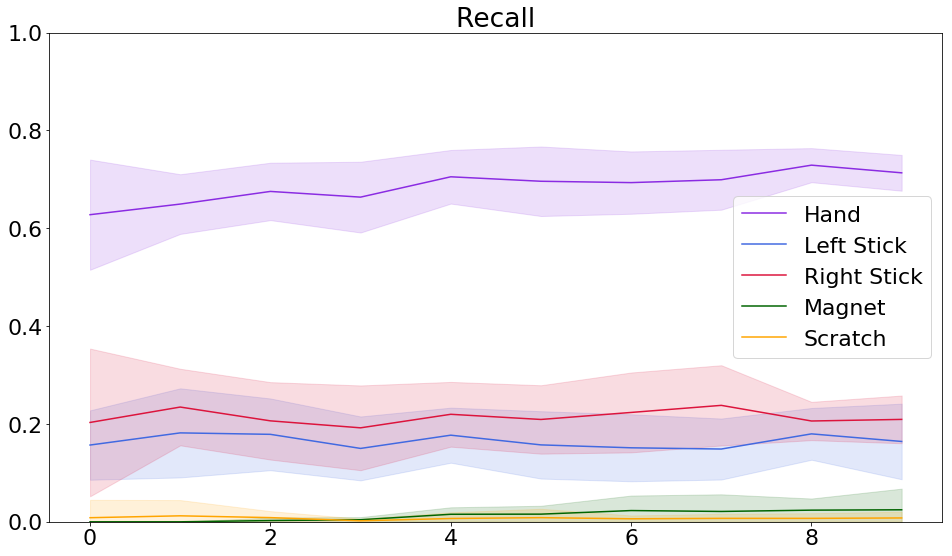

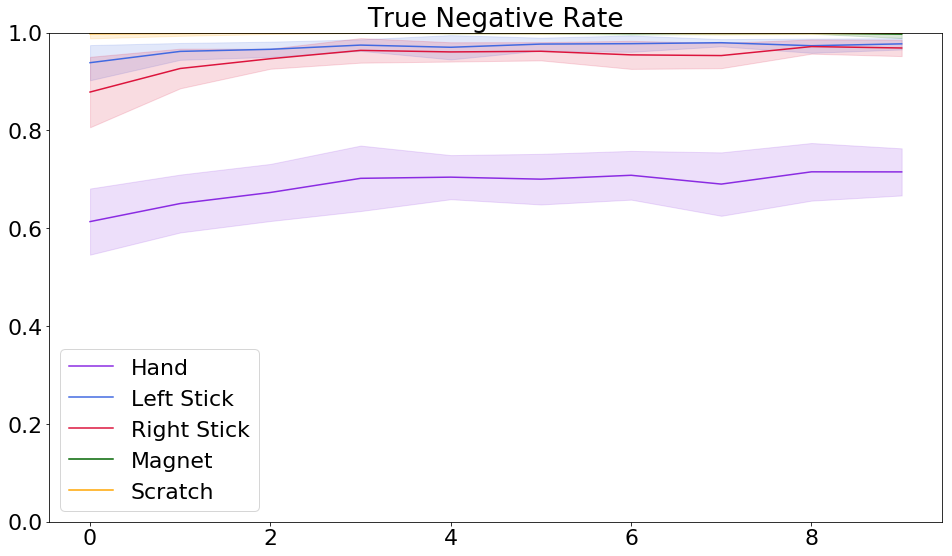

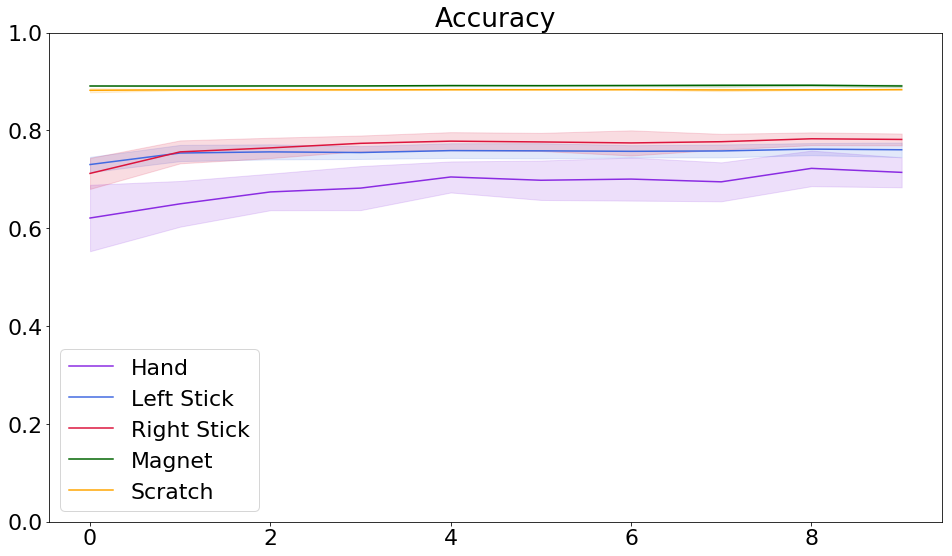

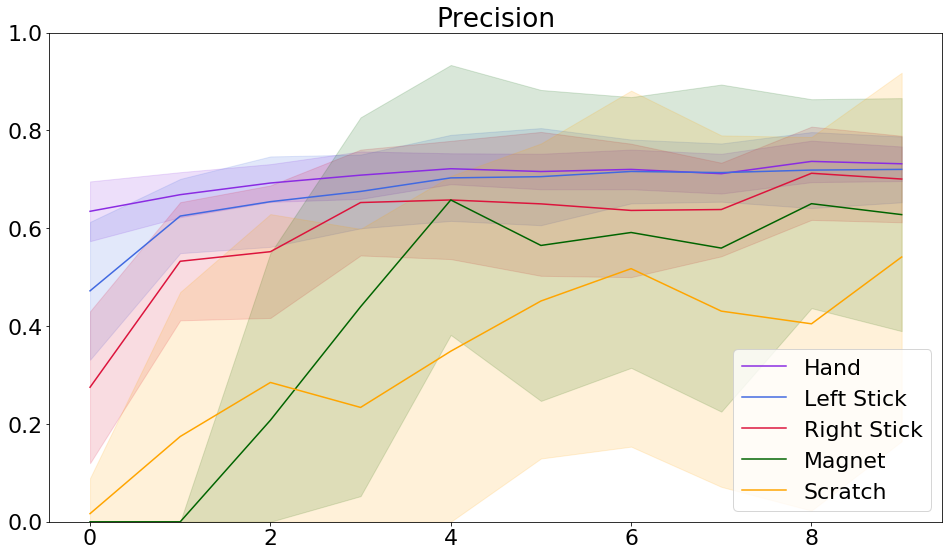

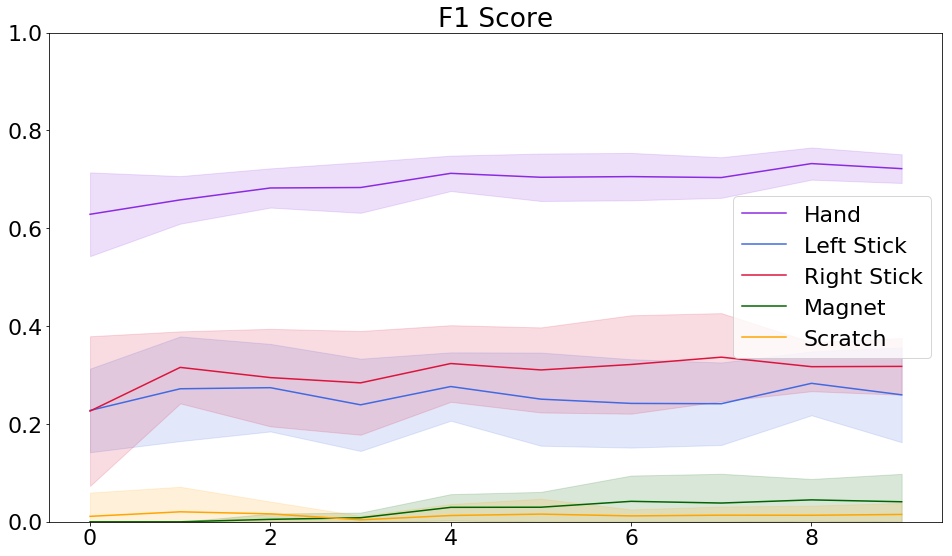

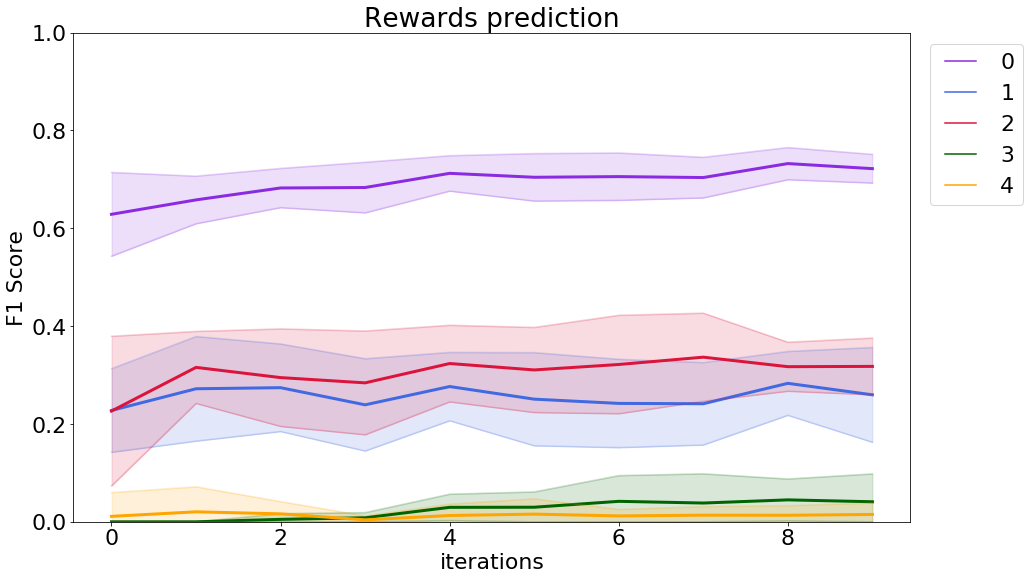

In [195]:
_, _, cf = confusion_matrix(subdirs, data_type=data_type, iterations=iterations, n_cpus=cpus)

In [ ]:
_ = compute_performance(subdirs, plot=True, full=False)

In [277]:
data = compute_coverage(subdirs,data_type, iterations=iterations, n_cpus=cpus)

In [268]:
plot_coverage(subdirs, data_type, iterations=iterations, n_cpus=cpus)

In [278]:
np.shape(data)

(20, 10, 5)

# Comparison params

In [240]:
def plot_objects(data, iterations, title, ylabel, minimum=0, maximum=np.inf, null_data=None,
                 log =False, ylim=False, has_legend=[0]):
    """ data [params, runs, iterations, objects] """
    fig,ax = plt.subplots(5,1, sharex=True,figsize=(8,10))
    
    objects = ['Hand', 'Left Stick','Right Stick', 'Magnet', 'Scratch']
    group_legend = [  obj+"\n"+ title for obj in objects]
    colors = ['royalblue','crimson','darkgreen','orange','blueviolet','grey']
    style = ['-','--',':',';']
    LW = 3
    
    for obj in range(5):
        plt.subplot(511+obj)
        if not null_data is None:
            plt.plot([1,iterations],[null_data[obj] for _ in range(2)],lw=LW, c='grey', label="Null model")
        for i in range(len(data)):
            mean = np.mean(data[i],axis=0)
            std = np.std(data[i], axis=0)
            #median = np.median(data[i],axis=0)
            if len(mean) != iterations:
                X = np.array(range(len(mean))) / 10
            else:
                X = range(1,iterations+1)
            color = colors[i]

            mean_p_std = np.minimum(mean[:,obj]+std[:,obj], maximum)
            mean_m_std = np.maximum(mean[:,obj]-std[:,obj], minimum)
            if obj in has_legend:
                plt.plot(X, mean[:,obj], c=color, lw=LW, label=names[i])
            else:
                plt.plot(X, mean[:,obj], c=color, lw=LW)
            #plt.plot(X, median[:,obj], c=color, ls='--', lw=5,label=names[i])
            plt.fill_between(X, mean_p_std, mean_m_std, color=color, alpha=0.15)
            #plt.title(group_legend[obj])
            if obj in has_legend:
                plt.legend()
            if log:
                plt.yscale('log')
            if ylim:
                plt.ylim((0,1))
            plt.ylabel(group_legend[obj])
            if obj == 4:
                plt.xlabel("Training episodes (x10³)")
            s = 1 if len(data) == 5 else 0
            plt.xticks(range(s,11), [str(10*i) for i in range(s,11)])
        name = title
        plt.savefig("/home/tim/Documents/figs/comparison_data/"+name+".svg", format='svg')

In [241]:
def plot_objects2(data, iterations, title, ylabel, minimum=0, maximum=np.inf, null_data=None,
                 log =False, ylim=False, has_legend=[0]):
    """ data [params, runs, iterations, objects] """
    fig,ax = plt.subplots(5,1, sharex=True,figsize=(8,10))
    
    objects = ['Hand', 'Left Stick','Right Stick', 'Magnet', 'Scratch']
    group_legend = [  obj+"\n"+ title for obj in objects]
    colors = ['royalblue','crimson','darkgreen','orange','blueviolet','grey']
    style = ['-','--',':',';']
    
    
    for obj in range(5):
        plt.subplot(511+obj)
        if not null_data is None:
            plt.plot([1,iterations],[null_data[obj] for _ in range(2)],lw=5, c='grey', label="Null model")
        for i in range(len(data)):
            mean = np.mean(data[i],axis=0)
            std = np.std(data[i], axis=0)
            median = np.median(data[i],axis=0)
            if len(mean) != iterations:
                X = np.array(range(len(mean))) / 10
            else:
                X = range(1,iterations+1)
            color = colors[i]
            for run in range(len(data[i])):
                plt.plot(X, np.array(data[i])[run,:,obj], c=color, lw=2, alpha=0.3)
            mean_p_std = np.minimum(mean[:,obj]+std[:,obj], maximum)
            mean_m_std = np.maximum(mean[:,obj]-std[:,obj], minimum)
            if obj in has_legend:
                plt.plot(X, mean[:,obj], c=color, lw=5, label=names[i])
            else:
                plt.plot(X, mean[:,obj], c=color, lw=5)
            #plt.plot(X, median[:,obj], c=color, ls='--', lw=5,label=names[i])
            #plt.fill_between(X, mean_p_std, mean_m_std, color=color, alpha=0.15)
            #plt.title(group_legend[obj])
            if obj in has_legend:
                plt.legend()
            if log:
                plt.yscale('log')
            if ylim:
                plt.ylim((0,1))
            plt.ylabel(group_legend[obj])
            if obj == 4:
                plt.xlabel("Training episodes (x10³)")
            s = 1 if len(data) == 5 else 0
            plt.xticks(range(s,11), [str(10*i) for i in range(s,11)])
        name = title
        plt.savefig("/home/tim/Documents/figs/comparison_data/"+name+".svg", format='svg')

### ATT random

In [280]:
path = "/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/"
# Random
random = [0,1,2,3,4,5,6,7,8,9]
# GRBF
grbf = [0,1,2,3,4,5,6,7,8,9]
#IMGEP
imgep = [0,1,2,3,4,5,6,7,8,9]
#EXPLO
explo = [0,1,2,3,4,5,6,7,8,9]
# Model_Free
model_free = [0]
# RL
rl = [0,1,2,3,4]

subdirs =[[path+"random_"+str(i) for i in random],
          [path+"grbf_"+str(i) for i in grbf],
          [path+"imgep_"+str(i) for i in imgep],
          [path+"explo_"+str(i) for i in explo],
          [path+"rl_"+str(i) for i in rl]
          ]


perf_subdirs=[[path+"random_"+str(i) for i in [0,1,2,3]],
              [path+"grbf_"+str(i) for i in [0,1,3]],
              [path+"imgep_"+str(i) for i in [0,2]],
              [path+"explo_"+str(i) for i in [0,1]],
              [path+"rl_"+str(i) for i in [0,1,2]]
              ]

data_type = 1
cpus = 20
names = ['Random', 'GRBF', 'IMGEP', "Exploration", "MBRL", "MFRL"]
iterations = 10

In [251]:
Traj, Trans, R_traj, R_trans = [], [], [], []
null_pred = prediction_errors(None,np.mean, data_type=0, iterations=0)
F1 = []
coverage = []
#perf = []
for param in subdirs:
    print(param)
    #F1.append(confusion_matrix(param, data_type=data_type, iterations=iterations, n_cpus=cpus, plot=False))
    #coverage.append(compute_coverage(param, data_type=data_type, iterations=iterations, n_cpus=cpus, plot=False))
    #perf.append(compute_performance(param, plot=False, full=False))
#perf = np.array(perf)
F1 = np.array(F1)
#coverage = np.array(coverage)


['/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_0', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_1', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_2', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_3', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_4', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_5', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_6', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_7', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_8', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_9']
['/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/grbf_0', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/grbf_1', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/grbf_2', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/grbf_3', '/home/tim/Documents/stage-m2/tf_test/lo

## Reward

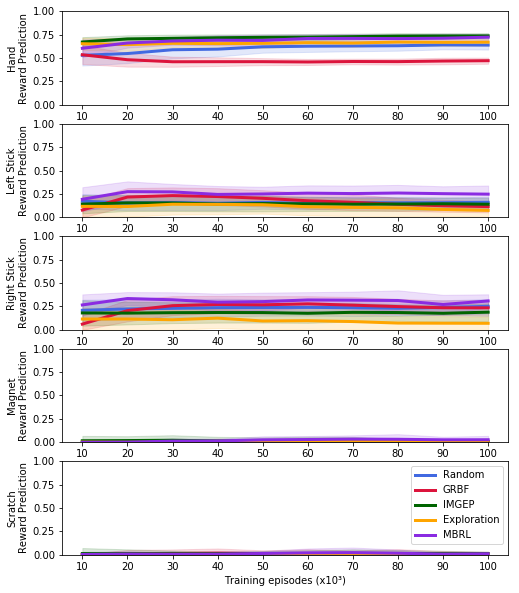

In [139]:
plot_objects(F1[:,0], iterations=iterations, title="Reward Prediction", ylabel="F1 score", ylim=True,
             minimum=0, maximum=1, has_legend=[4], null_data=F1[0,1],)

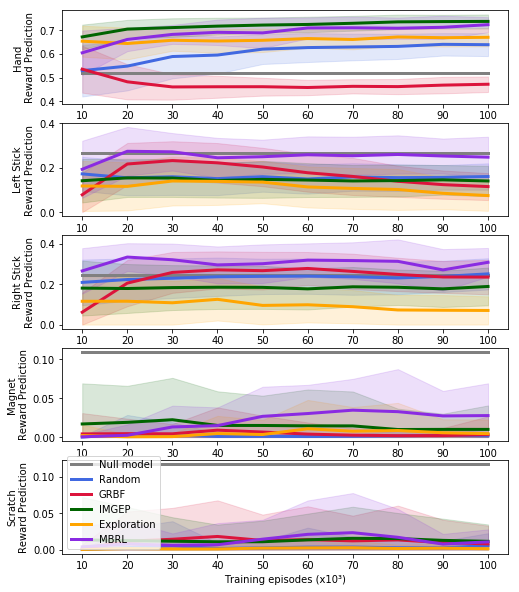

In [138]:
plot_objects(F1[:,0], iterations=iterations, title="Reward Prediction", ylabel="F1 score", 
             minimum=0, maximum=1, null_data=F1[0,1], has_legend=[4])

## Prediction

In [251]:
Traj, Trans, R_traj, R_trans = [], [], [], []
null_pred = prediction_errors(None,np.mean, data_type=0, iterations=0)
F1 = []
coverage = []
#perf = []
for param in subdirs:
    print(param)
    #F1.append(confusion_matrix(param, data_type=data_type, iterations=iterations, n_cpus=cpus, plot=False))
    #coverage.append(compute_coverage(param, data_type=data_type, iterations=iterations, n_cpus=cpus, plot=False))
    traj, trans, r_traj, r_trans = prediction_errors(param,np.median,data_type=data_type,iterations=iterations, n_cpus=cpus, plot=False)
    Traj.append(traj.copy())
    Trans.append(trans.copy())
    R_traj.append(r_traj.copy())
    R_trans.append(r_trans.copy())
    #perf.append(compute_performance(param, plot=False, full=False))
#perf = np.array(perf)
F1 = np.array(F1)
#coverage = np.array(coverage)


['/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_0', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_1', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_2', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_3', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_4', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_5', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_6', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_7', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_8', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_9']
['/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/grbf_0', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/grbf_1', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/grbf_2', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/grbf_3', '/home/tim/Documents/stage-m2/tf_test/lo

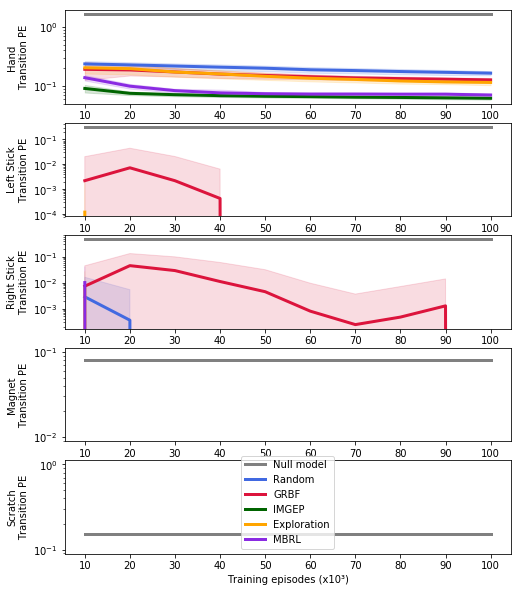

In [252]:
plot_objects(Trans, iterations=iterations, title="Transition PE", ylabel="Error", 
             log = True, null_data=null_pred[1], has_legend=[4])

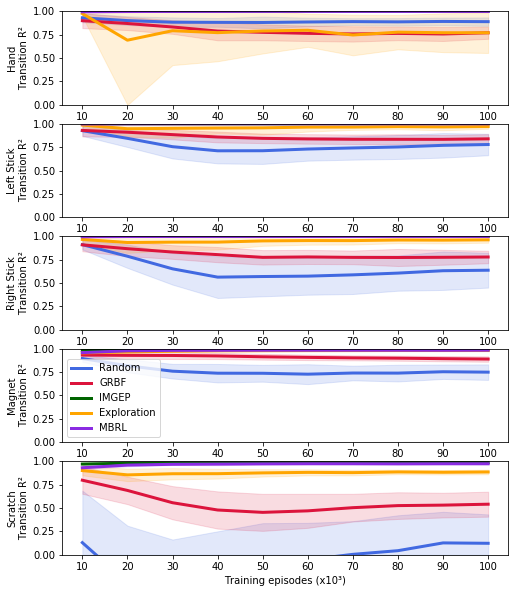

In [253]:
plot_objects(R_trans, iterations=iterations, title="Transition R²", ylabel="R²",has_legend=[3],
             minimum=0, maximum=1, ylim=True)

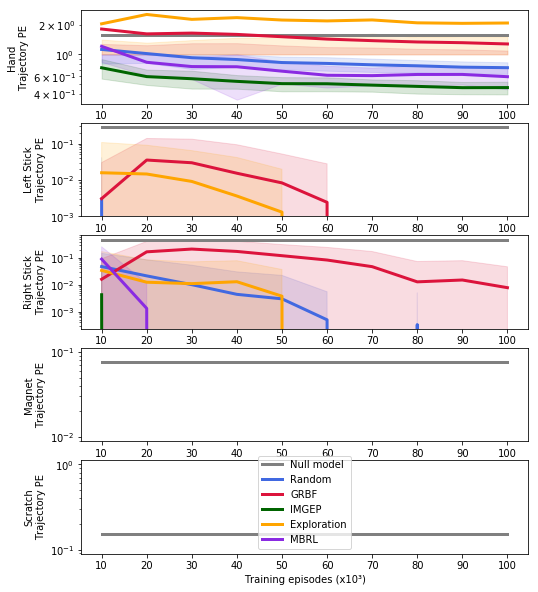

In [254]:
plot_objects(Traj, iterations=iterations, title="Trajectory PE", ylabel="", has_legend=[4],
             minimum=0, maximum=1,null_data=null_pred[0], log=True, ylim=False)

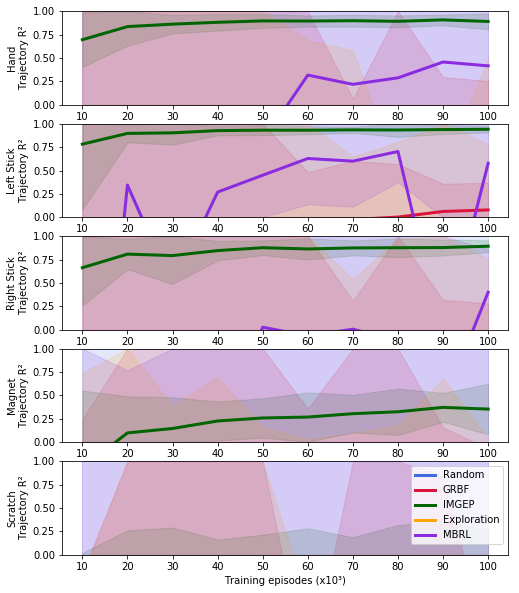

In [255]:
has_legend=[4],plot_objects(R_traj, iterations=iterations, title="Trajectory R²", ylabel="R²",has_legend=[4],
             minimum=0, maximum=1, ylim=True)

## Coverage


In [281]:
coverage = []
for param in subdirs:
    print(param)
    coverage.append(compute_coverage(param, data_type=data_type, iterations=iterations, n_cpus=cpus, plot=False))

['/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_0', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_1', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_2', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_3', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_4', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_5', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_6', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_7', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_8', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_9']
['/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/grbf_0', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/grbf_1', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/grbf_2', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/grbf_3', '/home/tim/Documents/stage-m2/tf_test/lo

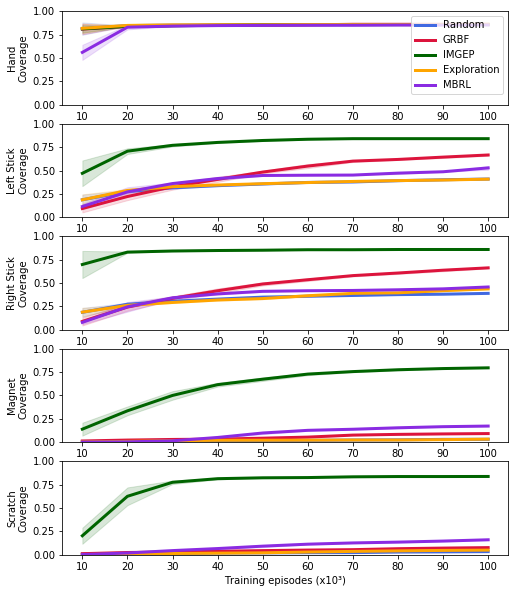

In [283]:
plot_objects(coverage, iterations=iterations, title="Coverage", ylabel="Coverage", minimum=0, maximum=1, ylim=True)

## Performance

In [76]:
perf = []
for param in perf_snull_pred = prediction_errors(None,np.mean, data_type=0, iterations=0)ubdirs:
    perf.append(compute_performance(param, plot=False, full=False))
perf = np.array(perf)

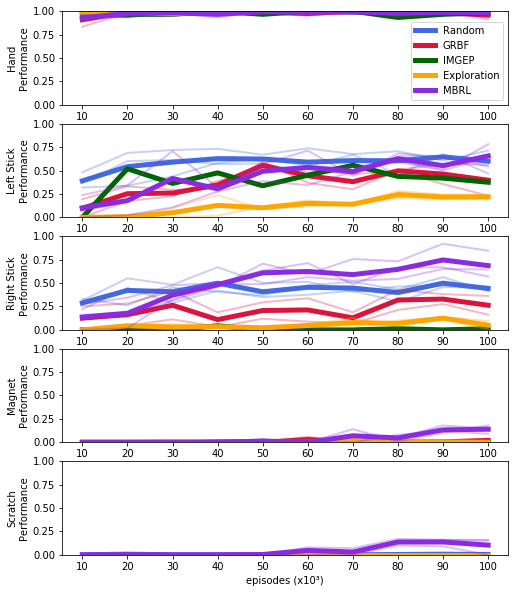

In [118]:
plot_objects2(perf, iterations=iterations, title="Performance", ylabel="Competence", 
              minimum=0, maximum=1, ylim=True, has_legend=[0])